# 赛题回顾

## 题目理解

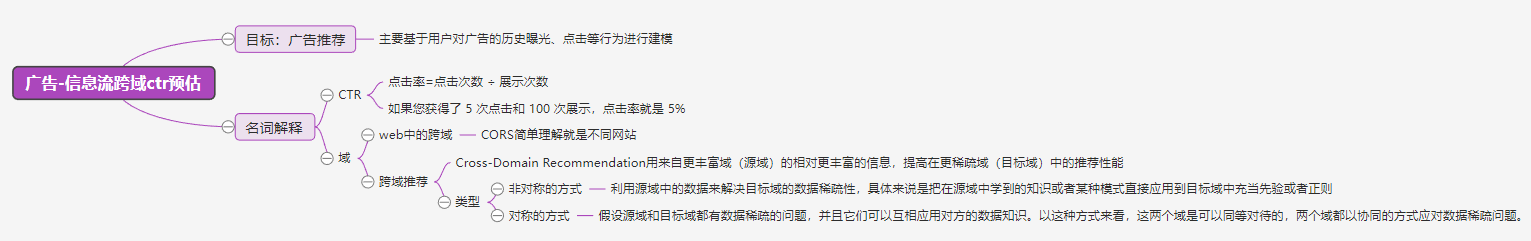

## 数据

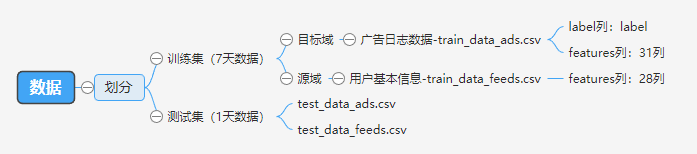

# 优化后的Baseline代码

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 导入库

In [2]:
# 导入库
# ---------------数据探索---------------
import pandas as pd
import numpy as np
import os
import gc  # 垃圾回收模块
import matplotlib.pyplot as plt
from tqdm import *
# ---------------核心模型---------------
import catboost
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
# ---------------交叉验证---------------
from sklearn.model_selection import StratifiedKFold, KFold
# ---------------评估指标---------------
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
# ---------------忽略报警---------------
import warnings
warnings.filterwarnings('ignore')

## 数据预处理

### 获取数据

In [3]:
# 获取数据
train_data_ads = pd.read_csv('/content/drive/MyDrive/Competitions/2022HuaWei-CTR/data/train/train_data_ads.csv')
train_data_feeds = pd.read_csv('/content/drive/MyDrive/Competitions/2022HuaWei-CTR/data/train/train_data_feeds.csv')

test_data_ads = pd.read_csv('/content/drive/MyDrive/Competitions/2022HuaWei-CTR/data/test/test_data_ads.csv')
test_data_feeds = pd.read_csv('/content/drive/MyDrive/Competitions/2022HuaWei-CTR/data/test/test_data_feeds.csv')


In [4]:
# 数据量太大了ram不够，只取原始数据的50%
# 比赛时请注释掉这一块
subsampleList = []
for df in [train_data_ads, train_data_feeds]:
    subsampleList.append(df.sample(n=int(df.shape[0] / 100 * 50), random_state=2022))
train_data_ads, train_data_feeds = subsampleList

In [5]:
print(train_data_ads.columns, '\n', train_data_feeds.columns, '\n', test_data_ads.columns, '\n', test_data_feeds.columns)

Index(['log_id', 'label', 'user_id', 'age', 'gender', 'residence', 'city',
       'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name',
       'device_size', 'net_type', 'task_id', 'adv_id', 'creat_type_cd',
       'adv_prim_id', 'inter_type_cd', 'slot_id', 'site_id', 'spread_app_id',
       'hispace_app_tags', 'app_second_class', 'app_score',
       'ad_click_list_v001', 'ad_click_list_v002', 'ad_click_list_v003',
       'ad_close_list_v001', 'ad_close_list_v002', 'ad_close_list_v003',
       'pt_d', 'u_newsCatInterestsST', 'u_refreshTimes', 'u_feedLifeCycle'],
      dtype='object') 
 Index(['u_userId', 'u_phonePrice', 'u_browserLifeCycle', 'u_browserMode',
       'u_feedLifeCycle', 'u_refreshTimes', 'u_newsCatInterests',
       'u_newsCatDislike', 'u_newsCatInterestsST', 'u_click_ca2_news',
       'i_docId', 'i_s_sourceId', 'i_regionEntity', 'i_cat', 'i_entities',
       'i_dislikeTimes', 'i_upTimes', 'i_dtype', 'e_ch', 'e_m', 'e_po', 'e_pl',
       'e_rn', 'e_section

### 处理特征穿越

In [6]:
# 处理特征穿越（题目禁止使用特征穿越）
# 特征穿越：建模过程中使用了未来数据，即引入了样本发生时刻之后的信息
# 特征穿越的后果：在线上推理时，特征中不再包含未来信息，会导致训练-应用偏差

# 比赛提供的数据包含一个时间戳字段，训练数据和测试数据中会存在时间重叠的部分，因此只能筛选出训练集中时间早于测试数据时间的部分
minDate = min(test_data_ads.pt_d.min(), test_data_feeds.e_et.min())
train_data_ads = train_data_ads[train_data_ads.pt_d < minDate]
train_data_feeds = train_data_feeds[train_data_feeds.e_et < minDate]

### 数据观察

In [7]:
# 数据观察
def StatsTrain(train):
  stats = []
  for col in train.columns:
    stats.append(
        (col, 
         train[col].nunique(), 
         round(train[col].isnull().sum() * 100 / train.shape[0], 6), 
         round(train[col].value_counts(normalize=True, dropna=False).values[0] * 100, 6),  # normalize=True 按比例从高到低输出每个值占比 
         train[col].dtype)
    )
  stats_df = pd.DataFrame(stats, columns=['特征','属性个数','缺失值占比','最多值占比','特征类型'])
  stats_df.sort_values('缺失值占比', ascending=False)  # 缺失值升序
  return stats_df

In [8]:
StatAds = StatsTrain(train_data_ads)
print(StatAds)

                      特征     属性个数  缺失值占比       最多值占比     特征类型
0                 log_id  1143948    0.0    0.000210    int64
1                  label        2    0.0   98.462917    int64
2                user_id    61475    0.0    0.045175    int64
3                    age        8    0.0   21.124146    int64
4                 gender        3    0.0   77.410038    int64
5              residence       35    0.0   13.496071    int64
6                   city      340    0.0   13.823079    int64
7              city_rank        4    0.0   41.564199    int64
8             series_dev       26    0.0   19.687868    int64
9           series_group        7    0.0   27.988024    int64
10              emui_dev       27    0.0   17.851817    int64
11           device_name      254    0.0    3.853491    int64
12           device_size     1372    0.0   18.864746    int64
13              net_type        6    0.0   72.984672    int64
14               task_id     9812    0.0    2.120251    int64
15      

In [9]:
StatFeeds = StatsTrain(train_data_feeds)
print(StatFeeds)

                      特征    属性个数     缺失值占比      最多值占比    特征类型
0               u_userId  138157  0.000000   0.039751   int64
1           u_phonePrice       7  0.000000  35.272913   int64
2     u_browserLifeCycle       8  0.000000  81.790587   int64
3          u_browserMode       8  0.000000  37.067668   int64
4        u_feedLifeCycle       8  0.000000  72.989495   int64
5         u_refreshTimes      10  0.000000  23.219372   int64
6     u_newsCatInterests  155759  0.000000   3.912894  object
7       u_newsCatDislike     726  0.000000  96.887792  object
8   u_newsCatInterestsST  427090  0.000000   9.874593  object
9       u_click_ca2_news  510141  0.000000   4.272805  object
10               i_docId   68284  0.000000   0.187010  object
11          i_s_sourceId    3249  0.000000   4.467407  object
12        i_regionEntity     370  0.000000  72.373886   int64
13                 i_cat     208  0.000000   9.809630   int64
14            i_entities   64479  3.229958   3.229958  object
15      

In [10]:
# 根据上面的分析可以看出，有numerical类型和category类型的数据，且存在数据缺失和样本极度不平衡的问题
# 一般来说遇到数据不平衡问题，需要进行欠采样或过采样的处理
# 假如是一个二分类问题，我们可以无脑输出不点击，正确率就有0.98

# 但是本次比赛是输出点击的概率（非常低），因此我们不对这些不平衡数据进行过多的处理

### 合并数据集

In [11]:
# 合并数据集 统一进行特征工程
train_data_ads['istest'] = 0
test_data_ads['istest'] = 1
data_ads = pd.concat([train_data_ads, test_data_ads], axis=0, ignore_index=True)

train_data_feeds['istest'] = 0
test_data_feeds['istest'] = 1
data_feeds = pd.concat([train_data_feeds, test_data_feeds], axis=0, ignore_index=True)

In [12]:
# 手动删除变量释放内存空间（因为比赛数据量太大了）
del train_data_ads, test_data_ads, train_data_feeds, test_data_feeds
gc.collect()

22

### 删除无意义特征

In [13]:
# 删除无意义特征
data_ads = data_ads.drop(columns=['log_id'])

## 特征工程

### 特征编码

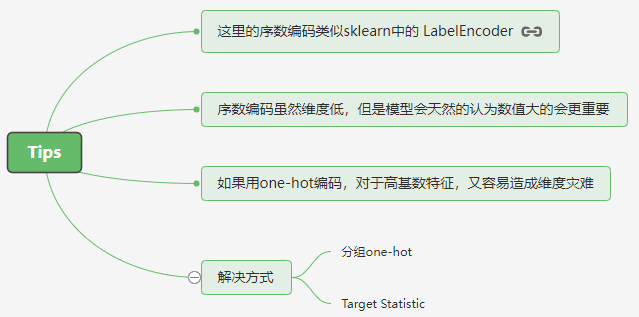

In [14]:
# 特征编码
# 对category类型数据进行LabelEncode
def label_encode(series, series2):
  unique = list(series.unique())
  return series2.map(dict(zip(unique, range(series.nunique()))))

In [15]:
for col in ['ad_click_list_v001', 'ad_click_list_v002', 'ad_click_list_v003', 'ad_close_list_v001', 'ad_close_list_v002', 'ad_close_list_v003', 'u_newsCatInterestsST']:
    data_ads[col] = label_encode(data_ads[col], data_ads[col])

### 特征创造

In [16]:
# 仅使用训练集数据进行构建，避免出现特征穿越问题
# 在这个代码中，只是用均值和nunique作为新特征
# 提分：考虑到时序特征，可以根据不同的时间窗口进行更多的特征创造，例如min、max、sum、diff等

In [17]:
train_feeds = data_feeds[data_feeds.istest == 0]
cols = [f for f in train_feeds.columns if f not in ['label','istest','u_userId']]
# 将feed中的数据按照用户分类，并计算nunique，作为新特征左联到data_ads中
for col in tqdm(cols):
  tmp = train_feeds.groupby(['u_userId'])[col].nunique().reset_index()
  tmp.columns = ['user_id', col+'_feeds_nuni']
  data_ads = data_ads.merge(tmp, on='user_id', how='left')

cols = [f for f in train_feeds.columns if f not in 
        ['istest', 'u_userId', 'u_newsCatInterests', 'u_newsCatDislike', 'u_newsCatInterestsST', 'u_click_ca2_news', 'i_docId', 'i_s_sourceId', 'i_entities']]
# 将feed中的数据按照用户分类，并计算均值，作为新特征左联到data_ads中
for col in tqdm(cols):
  tmp = train_feeds.groupby(['u_userId'])[col].mean().reset_index()
  tmp.columns = ['user_id', col+'_feeds_mean']
  data_ads = data_ads.merge(tmp, on='user_id', how='left')

100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


In [18]:
# 处理后的data_ads
StatDataAds = StatsTrain(data_ads)
print(StatDataAds)

                      特征   属性个数      缺失值占比      最多值占比     特征类型
0                  label      2  22.624310  76.186361  float64
1                user_id  63692   0.000000   0.044435    int64
2                    age      8   0.000000  21.147930    int64
3                 gender      3   0.000000  77.609198    int64
4              residence     36   0.000000  13.338209    int64
..                   ...    ...        ...        ...      ...
76  e_section_feeds_mean   1989   1.354828   4.448612  float64
77       e_et_feeds_mean  46518   1.354828   1.354828  float64
78      label_feeds_mean   1342   1.354828  14.452598  float64
79   cillabel_feeds_mean    101   1.354828  97.770456  float64
80        pro_feeds_mean   2924   1.354828  16.011914  float64

[81 rows x 5 columns]


## 模型训练

### 内存压缩

In [19]:
# 比赛数据量大时的常用技巧
# 原始的data_ads中数据类型为int64和float64，占用字节数量大，可以将其转换为占用字节少的数据类型

In [20]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
data_ads = reduce_mem_usage(data_ads)

Mem. usage decreased to 711.78 Mb (73.6% reduction)


### 划分训练集和测试集

In [22]:
# 划分数据集前，需对数据按时间进行排序，防止模型用到未来数据
# 同时，为了防止特征穿越，没有使用交叉验证
# baseline中，只对数据集进行简单的分割，为保证模型的平稳性，可用滚动窗口建模
data_ads = data_ads.sort_values('pt_d')
cols = [f for f in data_ads.columns if f not in ['label', 'istest']]
x_train = data_ads[data_ads.istest == 0][cols]
x_test = data_ads[data_ads.istest == 1][cols]

y_train = data_ads[data_ads.istest == 0]['label']

In [23]:
# 重置index
for df in [x_train, x_test, y_train]:
  df.index = range(0, df.shape[0])

In [24]:
trn_x, val_x, trn_y, val_y = train_test_split(x_train, y_train, test_size=0.33, shuffle=False)

### CatBoost

In [31]:
# params
params = {'iterations': 20000, 'learning_rate': 0.07, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                  'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}

In [32]:
# fit
model = CatBoostClassifier(**params, eval_metric='AUC',task_type="GPU")
model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
          cat_features=[],
          use_best_model=True,
          verbose=1)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6483110	best: 0.6483110 (0)	total: 35.9ms	remaining: 11m 58s
1:	total: 74.8ms	remaining: 12m 28s
2:	total: 115ms	remaining: 12m 43s
3:	total: 149ms	remaining: 12m 22s
4:	total: 183ms	remaining: 12m 11s
5:	test: 0.7522433	best: 0.7527117 (4)	total: 219ms	remaining: 12m 9s
6:	total: 259ms	remaining: 12m 20s
7:	total: 296ms	remaining: 12m 18s
8:	total: 329ms	remaining: 12m 10s
9:	total: 373ms	remaining: 12m 24s
10:	test: 0.7580937	best: 0.7586133 (9)	total: 408ms	remaining: 12m 21s
11:	total: 437ms	remaining: 12m 8s
12:	total: 472ms	remaining: 12m 5s
13:	total: 502ms	remaining: 11m 57s
14:	total: 531ms	remaining: 11m 47s
15:	test: 0.7645872	best: 0.7645872 (15)	total: 563ms	remaining: 11m 42s
16:	total: 593ms	remaining: 11m 36s
17:	total: 622ms	remaining: 11m 30s
18:	total: 652ms	remaining: 11m 25s
19:	total: 688ms	remaining: 11m 27s
20:	test: 0.7641726	best: 0.7645872 (15)	total: 720ms	remaining: 11m 24s
21:	total: 751ms	remaining: 11m 21s
22:	total: 782ms	remaining: 11m 18s
2

In [33]:
# predict
test_pred = model.predict_proba(x_test)[:, 1]

In [35]:
print(test_pred.shape)

(976058,)


In [37]:
# 输出并保存
res = pd.DataFrame()
res['pctr'] = test_pred
test_data_ads = pd.read_csv('/content/drive/MyDrive/Competitions/2022HuaWei-CTR/data/test/test_data_ads.csv')
res['log_id'] = test_data_ads['log_id']
res[['log_id', 'pctr']].to_csv('/content/drive/MyDrive/Competitions/2022HuaWei-CTR/submission2.csv', index=None)

## 超参数优化

对于gbdt的调参，一点建议，对于整个gbdt模型的影响最大的参数，一个是tree的数量，一个是max_depth深度，一个是行列采样的比例subsample，可以说是立竿见影的影响交叉验证的结果，其实用多了gbdt会发现很多超参数的设置对于最终模型效果的影响比较类似，有的参数稍微调整一点就变化很大，有的参数怎么调整变化都不太大

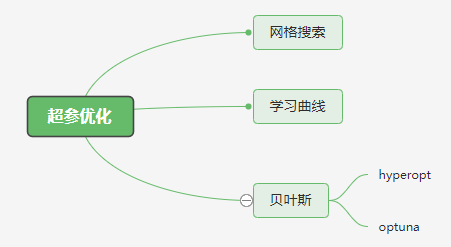

In [28]:
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
from hyperopt import hp, fmin, tpe
from hyperopt.pyll.base import scope
@scope.define
def to_int(x):
    return int(x)

space = {
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.5),
    'depth': scope.to_int(hp.quniform('depth', 3, 15, 1)),
    'iterations': 20000,
    'l2_leaf_reg': 10,
    'bootstrap_type': 'Bernoulli',
    'od_type': 'Iter',
    'od_wait': 50
}

numeric_train_pool = catboost.Pool(trn_x, trn_y)
numeric_val_pool = catboost.Pool(val_x, val_y)


def hyperopt_objective(params):
    model = CatBoostClassifier(**params, random_seed=42,task_type="GPU")
    model.fit(numeric_train_pool, verbose=0, eval_set=numeric_val_pool)
    y_pred = model.predict_proba(numeric_val_pool)
    return -roc_auc_score(numeric_val_pool.get_label(), y_pred[:, 1])

best = fmin(hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

100%|██████████| 20/20 [07:19<00:00, 21.99s/it, best loss: -0.7899918575360625]


In [30]:
print(best)

{'depth': 5.0, 'learning_rate': 0.07028080180516852}


# TODO
1. CatBoost的学习
2. 超参数优化方法学习
3. 进一步提升（利用时序特征）
4. [Day3答疑部分](https://meeting.tencent.com/user-center/shared-record-info?id=219ccbce-0815-4909-8088-845b828c18cc&from=3)
5. Day4腾讯会议

[讲解笔记](https://www.wolai.com/stupidccl/6ot8hzi4Au4m1c34QnzLNG)